https://tutorials.pytorch.kr/beginner/transformer_tutorial.html

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math
import numpy as np

In [34]:
def get_data(file_path):
    questions, answers = [], []
    with open(file_path, 'r') as f:
        for line in f:
            idx = line.find('_')
            questions.append(line[:idx].strip())
            answers.append(line[idx:-1].strip())
    return questions, answers

file_path = './addition.txt'
src_data, tgt_data = get_data(file_path)


class TokenizerPlus(Tokenizer):
        
    def to_tensor(self, texts, **kwargs):
        sequences = self.texts_to_sequences(texts)
        padded = pad_sequences(sequences, **kwargs)
        return torch.tensor(padded, dtype=torch.int64)
    
    def to_string(self, tensor):
        texts = self.sequences_to_texts(tensor.data.numpy())
        return [t[::2] for t in texts]
    
    
# 각 문자를 토큰으로 나눠주고 패딩 처리를 합니다.
tokenizer = TokenizerPlus(char_level=True, filters='')
tokenizer.fit_on_texts(src_data)
tokenizer.fit_on_texts(tgt_data)

src = tokenizer.to_tensor(src_data)
tgt = tokenizer.to_tensor(tgt_data, padding='post')

In [75]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, nhid, nlayers):
        super(TransformerModel, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.nhead = nhead
        self.nhid = nhid
        self.nlayers = nlayers
        
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead,
                                          num_encoder_layers=nlayers,
                                          num_decoder_layers=nlayers,
                                          dim_feedforward=nhid,
                                         )
        self.lin = nn.Linear(d_model, vocab_size)
                
    def forward(self, src, tgt, pad_id=0):
        mem, mk = self.encode(src, pad_id)
        return self.decode(tgt, mem, mk, pad_id)
    
    def encode(self, src, pad_id=0):
        x = self.emb(src) / math.sqrt(self.d_model)
        x = self.pe(x)
        mask = (src == pad_id)
        memory = self.transformer.encoder(x.transpose(0, 1), src_key_padding_mask=mask)
        return memory, mask
    
    def decode(self, tgt, memory, memory_mask, pad_id=0):
        x = self.emb(tgt) / math.sqrt(self.d_model)
        x = self.pe(x)
        
        tgt_mask = self.transformer.generate_square_subsequent_mask(x.size(1))
        out = self.transformer.decoder(x.transpose(0, 1), memory, 
                                       tgt_mask=tgt_mask,
                                       tgt_key_padding_mask=(tgt == pad_id),
                                       memory_key_padding_mask=memory_mask
                                       )
    
        return self.lin(out.transpose(0, 1))

    def greedy_decoding(self, src, start_token):
        N = src.size(0)
        mem, mk = self.encode(src)
        preds = tokenizer.to_tensor([start_token]*N)

        for _ in range(4):
            y_pred = self.decode(preds, mem, mk)
            t_pred = torch.argmax(y_pred[:,-1,:], axis=-1, keepdims=True)
            preds = torch.cat([preds, t_pred], axis=1)            

        return tokenizer.to_string(preds[:, 1:])

In [73]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer, pad_id=0, start_token='_'):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.pad_id = pad_id
        self.start_token = start_token
        self.losses = []
        self.current_epoch = 0
        
    def train(self, src, tgt, max_epoch=1, batch_size=128):
        X1_train = src
        X2_train = tgt[:, :-1]
        y_train = tgt[:, 1:]
        ds = TensorDataset(X1_train, X2_train, y_train)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        
        for epoch in range(1, max_epoch+1):
            self.model.train()
            running_loss = 0
            self.current_epoch += 1
            print("EPOCH: %s :: " %self.current_epoch, end='')
            for i, (x1, x2, yy) in enumerate(loader):
                y_pred = self.model(x1, x2, self.pad_id)
                loss = self.loss_fn(y_pred.view(-1, y_pred.size(-1)), yy.view(-1))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            
            running_loss = round(running_loss / (i+1), 3)
            self.losses.append(running_loss)
            acc = self.evaluate(src, y_train)
            print("Loss: %s" %(running_loss), "ACC: %s" %acc)
        
    def evaluate(self, src, y):
        pred = np.array(self.model.greedy_decoding(src, start_token='_'))
        y_text = np.array(tokenizer.to_string(y))
        acc = (pred == y_text).sum() / y_text.size
        return acc
    
model = TransformerModel(len(tokenizer.word_index)+1, 
                         d_model=64, nhead=4, 
                         nhid=256, nlayers=1)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

trainer = Trainer(model, loss_fn, optimizer)
trainer.train(src, tgt, max_epoch=20)

EPOCH: 1 :: Loss: 2.336 ACC: 0.0012
EPOCH: 2 :: Loss: 1.839 ACC: 0.00224
EPOCH: 3 :: Loss: 1.703 ACC: 0.00382
EPOCH: 4 :: Loss: 1.588 ACC: 0.00516
EPOCH: 5 :: Loss: 1.502 ACC: 0.00678
EPOCH: 6 :: Loss: 1.435 ACC: 0.00948
EPOCH: 7 :: Loss: 1.385 ACC: 0.0148
EPOCH: 8 :: Loss: 1.303 ACC: 0.02698
EPOCH: 9 :: Loss: 1.205 ACC: 0.03688
EPOCH: 10 :: Loss: 1.12 ACC: 0.04938
EPOCH: 11 :: Loss: 1.054 ACC: 0.07116
EPOCH: 12 :: Loss: 0.996 ACC: 0.09108
EPOCH: 13 :: Loss: 0.949 ACC: 0.11096
EPOCH: 14 :: Loss: 0.899 ACC: 0.13154
EPOCH: 15 :: Loss: 0.858 ACC: 0.15286
EPOCH: 16 :: Loss: 0.817 ACC: 0.16826
EPOCH: 17 :: Loss: 0.781 ACC: 0.18722
EPOCH: 18 :: Loss: 0.753 ACC: 0.20336
EPOCH: 19 :: Loss: 0.724 ACC: 0.222
EPOCH: 20 :: Loss: 0.698 ACC: 0.23696


In [203]:
test_str = tokenizer.texts_to_sequences(['45+45', '12+10', '11+13'])
test = torch.tensor(pad_sequences(test_str, maxlen=7), dtype=torch.int64)
trainer.predict(test)

['90', '22', '24']

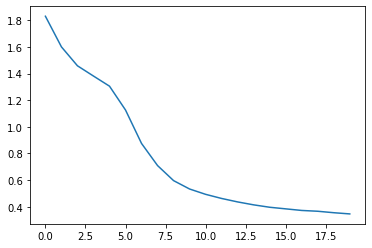

In [77]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses)
None